# CuisineCourse101
This is an personal project which aims at Image Classification for 101 food item classes.

In [1]:
# Getting some commonly used functions rom helper_functions.py

import os 

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

--2023-08-08 17:58:35--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: 'helper_functions.py'

     0K ..........                                            100% 1.02M=0.01s

2023-08-08 17:58:36 (1.02 MB/s) - 'helper_functions.py' saved [10246/10246]



In [2]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [3]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

C:\Users\kingm\anaconda3\envs\tfgpuenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load in the data 
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)


## Exploring the Food101 data from TensorFlow Datasets
Now we've downloaded the Food101 dataset from TensorFlow Datasets, Now we'll Visualize the data

Let's find out a few details about our dataset:

The shape of our input data (image tensors)
The datatype of our input data.
What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
Do the labels match up with the class names?

In [7]:
# Checking out the features
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [6]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [15]:
# Lets take one sample of the training data.
train_one_sample = train_data.take(1)

In [16]:
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [17]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 75
  Class name (str form): pho
        


It seems like the data is not one hot encoded

In [18]:
# What does our image datatype look like:-
image


<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 48,  51,  30],
        [ 49,  52,  31],
        [ 50,  55,  33],
        ...,
        [ 93, 120,  77],
        [ 87, 112,  70],
        [ 80, 105,  63]],

       [[ 43,  46,  25],
        [ 46,  49,  28],
        [ 49,  54,  32],
        ...,
        [ 95, 122,  77],
        [ 90, 117,  72],
        [ 83, 110,  65]],

       [[ 40,  43,  22],
        [ 45,  48,  27],
        [ 50,  55,  33],
        ...,
        [ 90, 119,  71],
        [ 87, 116,  68],
        [ 84, 113,  65]],

       ...,

       [[ 48,  55,  37],
        [ 48,  55,  37],
        [ 41,  50,  33],
        ...,
        [ 32,  43,  35],
        [ 25,  36,  30],
        [ 21,  32,  26]],

       [[ 42,  47,  27],
        [ 38,  46,  25],
        [ 34,  43,  26],
        ...,
        [ 38,  49,  41],
        [ 33,  44,  38],
        [ 29,  40,  34]],

       [[ 37,  42,  20],
        [ 32,  40,  19],
        [ 31,  38,  20],
        ...,
        [ 33,  44,  3

In [14]:
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Running the "train_one_sample = train_data.take(1)" cell again and again and by checking the shape of the image, it suggests that the shapes of the tensor images are very different from one another, so we need to also need to make them all similar by reshaping them

## Ploting an image from tenserflow dataset

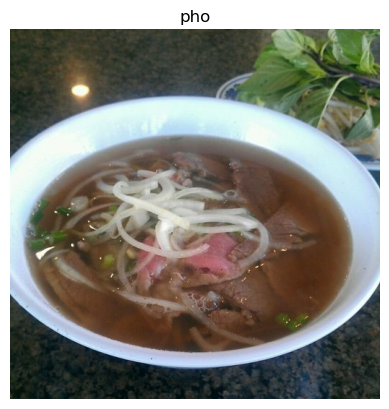

In [19]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

Delicious!

Now let's preprocess it and get it ready for use with a neural network.

## Creating preprocessing functions for the dataset